In [2]:
#Import packages
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute
import qiskit.quantum_info as qi
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms.time_evolvers.trotterization import TrotterQRTE
from qiskit.primitives import Estimator
from qiskit import Aer
from qiskit.visualization import array_to_latex


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math
from tqdm import tqdm

In [425]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = 'all'


## 1) Dynamic evolution for two spin-1/2 particles

In [23]:
#create the initial state |00>
qreq = QuantumRegister(size = 2)
#creq = ClassicalRegister(size = 1)
qcir = QuantumCircuit(qreq)


#Define the hamiltonian
omega_1 = .5
omega_2 = .3
lambda_inter = 0.5
hamiltonian = qi.SparsePauliOp(data =["XI", "IX", "ZZ"], coeffs = [-omega_1, -omega_2, lambda_inter])

#Define the observable and the estimator
obs1 = qi.SparsePauliOp(data = ["ZI"], coeffs = [0.5])
obs2 = qi.SparsePauliOp(data = ["IZ"], coeffs = [0.5])
estimator = Estimator()


#Define the evolution problem
time = 50
# initial_state = qcir
# initial_state = np.sqrt(1/2)*(qi.Statevector.from_label("00")+qi.Statevector.from_label("11"))
initial_state = qi.Statevector.from_label("00")

problem = TimeEvolutionProblem(hamiltonian,time,initial_state,aux_operators=[obs1, obs2])


#Evolve the system
num_timesteps = 200
evolution = TrotterQRTE(estimator=estimator, num_timesteps=num_timesteps).evolve(problem)


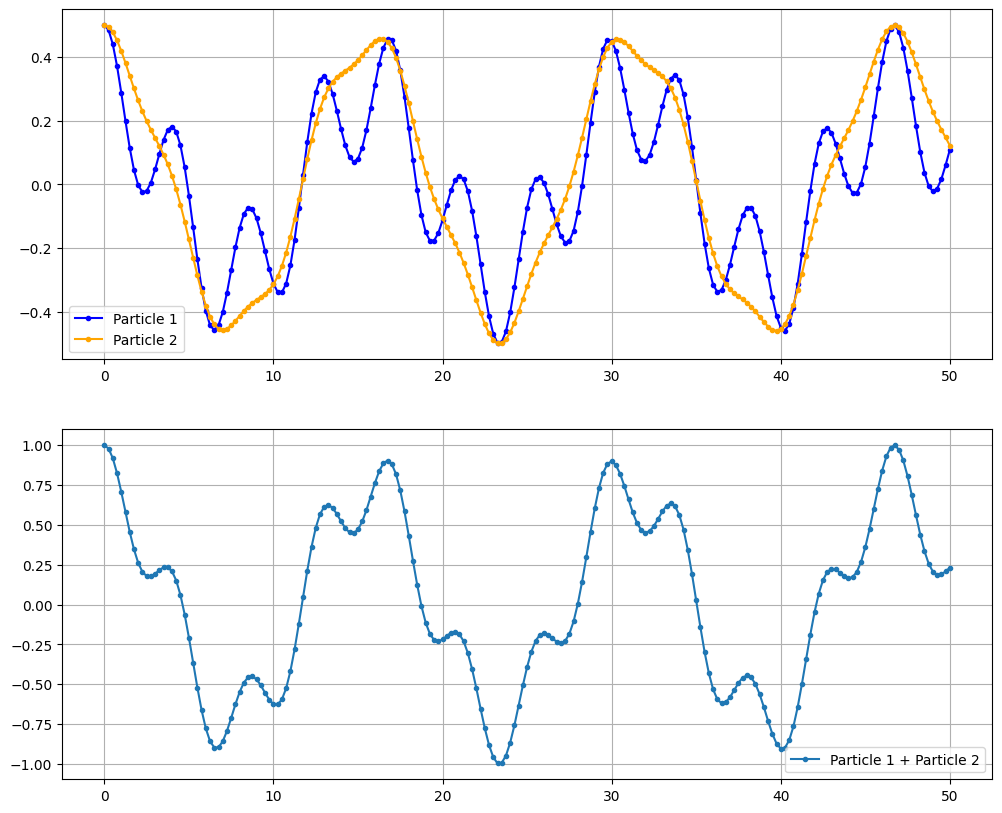

In [24]:
#Get the observable values
obs_values = np.array(evolution.observables)[:,:,0]

obs1 = obs_values[:,0]
obs2 = obs_values[:,1]

x_times = np.linspace(0,time,num=num_timesteps+1)
fig, ax = plt.subplots(2,1, figsize=(12, 10))

ax[0].plot(x_times,obs1,'.-', color = 'blue', label='Particle 1') # mean value of sigma_z for particle 1
ax[0].plot(x_times,obs2,'.-', color = 'orange', label = 'Particle 2') # mean value of sigma_z for particle 2

ax[0].legend()
ax[0].grid()

ax[1].plot(x_times, obs1+obs2, '.-', label = "Particle 1 + Particle 2") # mean value of sigma_z for particle 1+2
ax[1].legend()
ax[1].grid()


## 2) Dynamic evolution for two spin-1/2 particles with spontaneous collapse

In [43]:
def _collapse_times(time, lam):
    """
    Generate an array of value with poisson distribution that represent the collapses.

    Parameter:
        - time(int): Max time of the experiment, the last collapse must to be before the max time
        - lam(float): Mean value of the poisson distribution that represents the rate of appearence of the collapses

    Return:
        - collapse_array(np.array): Array of sampled element from the poisson distribution 
    
    """
    t_run = 0 # count at which time we are when we sample a new value from the poisson distribution
    collapse_array = []
    while t_run <= time:
        t = np.random.poisson(lam,size=1)
        if t == 0: # beacuse the collapse doesn't happen at the same time of the previous one
            continue
        t_run += t
        if t_run <= time:
            collapse_array.append(t)
    
    return np.array(collapse_array)[:,0]

def t_coll(collapse_times):
    """
    This function calculate the exact time at which the collapses happened. This values are used in the plots

    Parameter:
        - collapse_time(np.array): Array of sampled element from the poisson distribution 

    Return:
        - t_collapses(list): Time series of the collapses
    """
    t_collapses = []
    for i in range(len(collapse_times)):
        if i == 0:
            t_collapses.append(collapse_times[0])
        else:
            t_collapses.append(t_collapses[-1] + collapse_times[i])
    return t_collapses

def QRTE_evolution(hamiltonian, t_col, initial_state, n_timesteps, obs):
    """
    Apply the trotterization to obtain the resulting state and the mean value of the observable
    
    Parameter:
        - hamiltonian(BaseOperator | PauliSumOp): The Hamiltonian under which to evolve the system.
        - t_col(float): Total time of evolution
        - initial state(QuantumCircuit): The quantum state to be evolved
        - n_timesteps(int): he number of time-steps the full evolution time is devided into 
        - obs(ListOrDict[BaseOperator | PauliSumOp] | None): Optional list of auxiliary operators to be evaluated with the evolved initial_state and their expectation values returned.

    Return:
        - evolution(qiskit object): object that represent the result of the evolution. It must to be used then to extract the circuit after the evolution
        - obs_values(np.array): Array of mean values of the operator that is evaluated with the evolved initial_state

    """
    problem = TimeEvolutionProblem(hamiltonian, t_col, initial_state, aux_operators = obs)
    evolution = TrotterQRTE(estimator = estimator, num_timesteps = n_timesteps).evolve(problem)
    obs_values = np.array(evolution.observables)[:,:,0]

    return evolution, obs_values

def merge_time_series(time1, time2):
    """
    This function merge the two list of samples coming from the poisson distribution and represente the time of collapses of the two particle. 
    
    Parameters:
        - time1(np.array|list): Array of samples coming from the poisson distribution for the first particle
        - time2(np.array|list): Array of samples coming from the poisson distribution for the second particle

    Return:
        - final_list(np.array): An array of 4 raws, in the first the interval time between one collapse and another, 
                                                    the second the time series of the collapses, 
                                                    the third is made of 0 and 1, if the particle 1 collapse in that time
                                                    the fourth is made of 0 and 1, if the particle 2 collapse in that time
    """ 

    time_series_merge = [] # list for the merged time series
    coll_part_1 = [] # list to know when the particle one collapse
    coll_part_2 = [] # list to know when the particle two collapse
    intervall_list = [] # list to storage the interval between one collapse and another, in theory this is poisson distributed

    x_t1 = t_coll(time1) # the time series for the first list of poisson samples
    x_t2 = t_coll(time2) # # the time series for the second list of poisson samples

    # MERGE THE TIME SERIES AND BUILD THE LIST TO KNOW WHEN THE PARTICLE COLLAPSE

    #define some auxiliary list
    x_timed1 = x_t1 
    x_timed2 = x_t2 

    while len(x_timed1) > 0 and len(x_timed2) > 0:

        x = x_timed1[0]
        y = x_timed2[0]

        if x < y:
            time_series_merge.append(x) # append to the list of the time series the value coming from the series of the particle 1
            coll_part_1.append(1) # append one so we know the particle one collapse
            coll_part_2.append(0) # append zero so we know the particle two doesn't collapse
            x_timed1 = x_timed1[1:] # delete from the list the first value

        elif x > y:
            time_series_merge.append(y) # append to the list of the time series the value coming from the series of the particle 2
            coll_part_1.append(0)
            coll_part_2.append(1)
            x_timed2 = x_timed2[1:] # delete from the list the first value
        elif y == x:
            time_series_merge.append(x) # append to the list of the time series the value coming from both particles because are at the same time
            coll_part_1.append(1)
            coll_part_2.append(1)
            x_timed1 = x_timed1[1:] # delete from the list the first value
            x_timed2 = x_timed2[1:] # delete from the list the first value

    # append the last term, the big one
    if x_t1[-1] < x_t2[-1]:
        time_series_merge.append(x_t2[-1])
        coll_part_1.append(0)
        coll_part_2.append(1)
    elif x_t1[-1] > x_t2[-1]:
        time_series_merge.append(x_t1[-1])
        coll_part_1.append(1)
        coll_part_2.append(0)

    # calculate now the interval between one collapse and another
    intervall_list.append(time_series_merge[0])

    for i in range(len(time_series_merge)-1):
        intervall_list.append(time_series_merge[i+1]-time_series_merge[i])

    return np.array([intervall_list, time_series_merge, coll_part_1, coll_part_2])

def dynamic(hamiltonian, initial_state, t_col, n_timesteps, obs, coll_1, coll_2):
    """
    Evaluate the dynamic until the time of collapse, then evaluate the collapse generating a random number between 0 and 1 and compare with the prob of the stato to be in |0>.

    Parameter:
        - hamiltonian(BaseOperator | PauliSumOp): The Hamiltonian under which to evolve the system.
        - initial state(QuantumCircuit): The quantum state to be evolved
        - t_col(float): Total time of evolution
        - n_timesteps(int): he number of time-steps the full evolution time is devided into 
        - obs(ListOrDict[BaseOperator | PauliSumOp] | None): Optional list of auxiliary operators to be evaluated with the evolved initial_state and their expectation values returned.
        - coll_1(int): =1 if the particle 1 collapse, =0 if it doesn't collapse
        - coll_2(int): =1 if the particle 2 collapse, =0 if it doesn't collapse
    
    Return:
        - res_state(statevector): the state after the collapse
        - obs_values(np.array): Array of mean values of the operator that is evaluated with the evolved initial_state
        - where_collapse(np.array): Array to know where the particles collapse, extended explanation after in the definition of the variable
    """

    #--------DYNAMIC----------
    evolution, obs_values = QRTE_evolution(hamiltonian, t_col, initial_state, n_timesteps, obs)
    state = evolution.evolved_state  # extract the circuit from the ouput of the QRTE_evolution 
    c_reg = ClassicalRegister(2) # define a classic register to perform the measure
    state.add_register(c_reg) # add the classic register to the circuit
    
    # -------------------
    # ---- COLLAPSE -----
    # -------------------
    backend = Aer.get_backend("statevector_simulator") # The backend for the measure after the collapse

    matrix_obs1 = np.array(obs[0].to_matrix()) #convert the obs0 in a np.array
    matrix_obs2 = np.array(obs[1].to_matrix()) #convert the obs1 in a np.array

    where_collapse = np.full(2, 2)  # this array is used to know where each particle is collapsed, 
                                    # if the value is 2 than there is not collapse
                                    # if it is 0 it collaps in |0>
                                    # if it is 1 it collaps in |1>

    # the order is |00>, |01>, |10>, |11> and qiskit swap the order of the qubit

    # COLLAPSE PARTICLE 1
    if coll_1 == 1 and coll_2 == 0: # only the first particle collapse here
        state.measure(0, c_reg[0])
        res_state = execute(state, backend).result().get_statevector(state) 

        # see if the particle is collapsed in |0> or |1>

        res_state_vector = np.asarray(res_state.tolist()) # convert the output state in a np.array
        mean_sigma_z1 = np.real(np.conj(res_state_vector).T @ matrix_obs1 @ res_state_vector) #calculate mean value of sigma_z for particle 1 to understand if it's collapse in |0> or |1>

        if mean_sigma_z1 > 0:   # collapse in |0>
            where_collapse[0] = 0
        else:                   # collapse in |1>
            where_collapse[0] = 1
 
    # COLLAPSE PARTICLE 2
    elif coll_1 == 0 and coll_2 == 1: # only the second particle collapse here
        state.measure(1, c_reg[0])
        res_state = execute(state, backend).result().get_statevector(state)

        # see if the particle is collapsed in |0> or |1>

        res_state_vector = np.asarray(res_state.tolist()) # convert the output state in a np.array
        mean_sigma_z2 = np.real(np.conj(res_state_vector).T @ matrix_obs2 @ res_state_vector) #calculate mean value of sigma_z for particle 1 to understand if it's collapse in |0> or |1>

        if mean_sigma_z2 > 0:   # collapse in |0>
            where_collapse[1] = 0
        else:                   # collapse in |1>
            where_collapse[1] = 1
        
    # COLLAPSE PARTICLE 1 AND 2
    elif coll_1 == 1 and coll_2 == 1: # both particle collapse
        state.measure(0, c_reg[0])
        state.measure(1, c_reg[1])
        res_state = execute(state, backend).result().get_statevector(state)

        # see if the particles are collapsed in |0> or |1>

        res_state_vector = np.asarray(res_state.tolist()) # convert the output state in a np.array
        mean_sigma_z1 = np.real(np.conj(res_state_vector).T @ matrix_obs1 @ res_state_vector) #calculate mean value of sigma_z for particle 1 to understand if it's collapse in |0> or |1>
        mean_sigma_z2 = np.real(np.conj(res_state_vector).T @ matrix_obs2 @ res_state_vector) #calculate mean value of sigma_z for particle 1 to understand if it's collapse in |0> or |1>

        if mean_sigma_z1 > 0:   # collapse in |0>
            where_collapse[0] = 0
        else:                   # collapse in |1>
            where_collapse[0] = 1

        if mean_sigma_z2 > 0:   # collapse in |0>
            where_collapse[1] = 0
        else:                   # collapse in |1>
            where_collapse[1] = 1  

    return res_state, obs_values, where_collapse

def experiment(hamiltonian, initial_state, time, num_timesteps, collapse_times, obs):
    """
    Apply the dynamics for the whole experiment until the end of the time of the experiment and store the values of obs_values, 
    the number of collpases in |0>, |1> for both particle and the time series of collapses.
    
    Parameter:
        - hamiltonian(BaseOperator | PauliSumOp): The Hamiltonian under which to evolve the system.
        - initial state(QuantumCircuit): The quantum state to be evolved
        - time(int): Total time of the experiment
        - num_timesteps(int): Number of steps in which is divide the whole experiment
        - collapse_times(np.array): Array coming from the merge_time_series function
        - obs(ListOrDict[BaseOperator | PauliSumOp] | None): Optional list of auxiliary operators to be evaluated with the evolved initial_state and their expectation values returned.

    Return:
        - obs_values_1(list_float): All the values of the mean value of the observable operator for particle 1
        - obs_values_1(list_float): All the values of the mean value of the observable operator for particle 2
        - counter(np.array): Array of 4 elements:   the first element is how many time the particle one collapse in |0>
                                                    the second element is how many time the particle one collapse in |1>
                                                    the third element is how many time the particle one collapse in |0>
                                                    the fourth element is how many time the particle one collapse in |1>
        - collapse_time(np.array):  It's the same of the input, but know in the raws where we see if one of the particles collapse we add the information that if it collapse in |0> with values +1 or in |1> with values -1
                                    This is used than to plot the dot of the collapses
    
    """             
    
    counter = np.zeros(4) # counter for counting how many times the collapses are in |0> and |1> for both particles
    
    obs_values_1 = [] # list to append the mean values of the observable 
    obs_values_2 = [] # list to append the mean values of the observable 

    N = collapse_times.shape[1] # total collapse in the whole experiment

    collapse_timesteps = collapse_times[0]*int(num_timesteps/time) # steps for each interval between two collapses

    #experiment until the last collapse
    for i in tqdm(range(N)):
        coll_1 = collapse_times[2,i] # if the particle 1 collapse in this interval
        coll_2 = collapse_times[3,i] # if the particle 2 collapse in this interval
        state, obs_values, where_collapse = dynamic(hamiltonian, initial_state, collapse_times[0,i], collapse_timesteps[i], obs, coll_1, coll_2)

        # count the total amount of collapses
        
        if where_collapse[0] == 0: # particle one
            counter[0] +=1
        elif where_collapse[0] == 1:
            counter[1] +=1
            collapse_times[2,i] = -1
        
        if where_collapse[1] == 0: # particle two
            counter[2] +=1
        elif where_collapse[1] == 1:
            counter[3] +=1
            collapse_times[3,i] = -1

        # store the value of the observable
        for j in range(obs_values.shape[0]):
            obs_values_1.append(obs_values[j,0]) # obs1
            obs_values_2.append(obs_values[j,1]) # obs2

        initial_state = state # redefine the initial state as the final state of the last interval 

    # last piece of experiment from the last collaps to the end of the time
    if collapse_times[1,-1] != time:
        time_fin = time - collapse_times[1,-1]
        timesteps_fin = num_timesteps - np.sum(collapse_timesteps)
        _, obs_values = QRTE_evolution(hamiltonian, time_fin, initial_state, timesteps_fin, obs)

        # store the value of the observable
        for j in range(obs_values.shape[0]):
            obs_values_1.append(obs_values[j,0]) # obs1
            obs_values_2.append(obs_values[j,1]) # obs2
            
    return obs_values_1, obs_values_2, counter, collapse_times

def divide_collapses(count, coll):
    """
    Given the array of collapses for both particle extract the time at which each particle collaps and where (1,-1) to use than this information in the plot

    Parameters:
        - count(np.array): Output from the experiment function that count how many times each particle collapse in |0> or |1>
        - coll(np.array): Array come from the experiment function that regroup the information for both the particle 

    Return:
        - collapse_1,2(np.array): Array of two raws, the first show when the particle is collapse and the second where(1,-1)
    """

    n1 = int(count[0]+count[1]) # n collapses for particle 1
    n2 = int(count[2]+count[3]) # no collapses for particle 2

    collapse_1 = np.zeros((2,n1))
    collapse_2 = np.zeros((2,n2))

    cont_1 = 0 
    cont_2 = 0    

    for i in range(coll.shape[1]):
        if coll[2,i] == 1: # if the particle 1 is collapsed in |0>
            collapse_1[0,cont_1] = coll[1,i]
            collapse_1[1,cont_1] = coll[2,i]
            cont_1 +=1
        elif coll[2,i] == -1: # if the particle 1 is collapsed in |1>
            collapse_1[0,cont_1] = coll[1,i]
            collapse_1[1,cont_1] = coll[2,i]
            cont_1 +=1

        if coll[3,i] == 1: # if the particle 2 is collapsed in |0>
            collapse_2[0,cont_2] = coll[1,i]
            collapse_2[1,cont_2] = coll[3,i]
            cont_2 += 1
        elif coll[3,i] == -1: # if the particle 2 is collapsed in |1>
            collapse_2[0,cont_2] = coll[1,i]
            collapse_2[1,cont_2] = coll[3,i]
            cont_2 += 1
    return collapse_1, collapse_2

def plot_animation_2(X, Y, Z, true_lam, time, save_as_gif=False):
    """
    This function create the animation through a gif using matplotlib for two plot respect the same axes
    Parameters:
        - X(np.array): Array with the values for the x-axe
        - Y(np.array): Array with the values with the first particle mean values of sigma_z
        - Z(np.array): Array with the values with the second particle mean values of sigma_z
        - true_lam(float): Value of lambda for the collapse theory
        - time(int): Total time of the experiment
        - save_as_gif(Bool): True if the function save the gif in local
    Return:
        - The animation through a gif
    """

    n = len(X) # number of data

    # define the plot
    fig = plt.figure(figsize=(12,8))

    plt.xlim([-5, time+5])
    plt.ylim([-.55,.55])
    plt.title(f'Collapse Model for 2 spin with λ = {"{:.2f}".format(true_lam)}')
    plt.xlabel("Time")
    plt.ylabel("Mean value of Sigma z")
    plt.grid(True)
    
    line1, = plt.plot([], [], '.-', label='particle 1', color = 'blue')  # Plot for X vs Y
    line2, = plt.plot([], [], '.-', label='particle 2', color = 'orange')  # Plot for X vs Z
    
    # for save each fram
    def update(frame):
        line1.set_data(X[:frame], Y[:frame])
        line2.set_data(X[:frame], Z[:frame])
        return line1, line2
    
    #The interval parameter represents the delay between frames in milliseconds.
    ani = FuncAnimation(fig, update, frames=range(n), blit=True, interval=15)  # Set fps to 15
    
    plt.legend()
    
    if save_as_gif:
        ani.save("animation_2.gif", writer='pillow')  # Save the animation as a .gif file
    
    plt.tight_layout()
    plt.show()

In [36]:
time = 100
lam = 10
true_lam = 1/lam # true lambda to use in the plot title
num_timesteps = 1000

#Define the hamiltonian
omega_1 = .3
omega_2 = .09
lambda_inter = .15
hamiltonian = qi.SparsePauliOp(data =["XI", "IX", "ZZ"], coeffs = [-omega_1, -omega_2, lambda_inter])

#Define the observable and the estimator
obs1 = qi.SparsePauliOp(data = ["ZI"], coeffs = [0.5])
obs2 = qi.SparsePauliOp(data = ["IZ"], coeffs = [0.5])
obs = [obs1, obs2]
estimator = Estimator()

# initial state
initial_state = qi.Statevector.from_label("00")

# generate poisson samples
x1 = _collapse_times(time, lam)
x2 = _collapse_times(time, lam)

# merge them
t = merge_time_series(x1, x2) 


In [37]:
# experiment
y1, y2, count, coll = experiment(hamiltonian, initial_state, time, num_timesteps, t, obs)

c1,c2 = divide_collapses(count, coll)


  0%|          | 0/18 [00:00<?, ?it/s]/var/folders/8r/rk87_q2x6q73135zrfmsjxgw0000gn/T/ipykernel_60094/2536496095.py:197: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  res_state_vector = np.asarray(res_state.tolist()) # convert the output state in a np.array
  6%|▌         | 1/18 [00:01<00:18,  1.06s/it]/var/folders/8r/rk87_q2x6q73135zrfmsjxgw0000gn/T/ipykernel_60094/2536496095.py:182: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objec

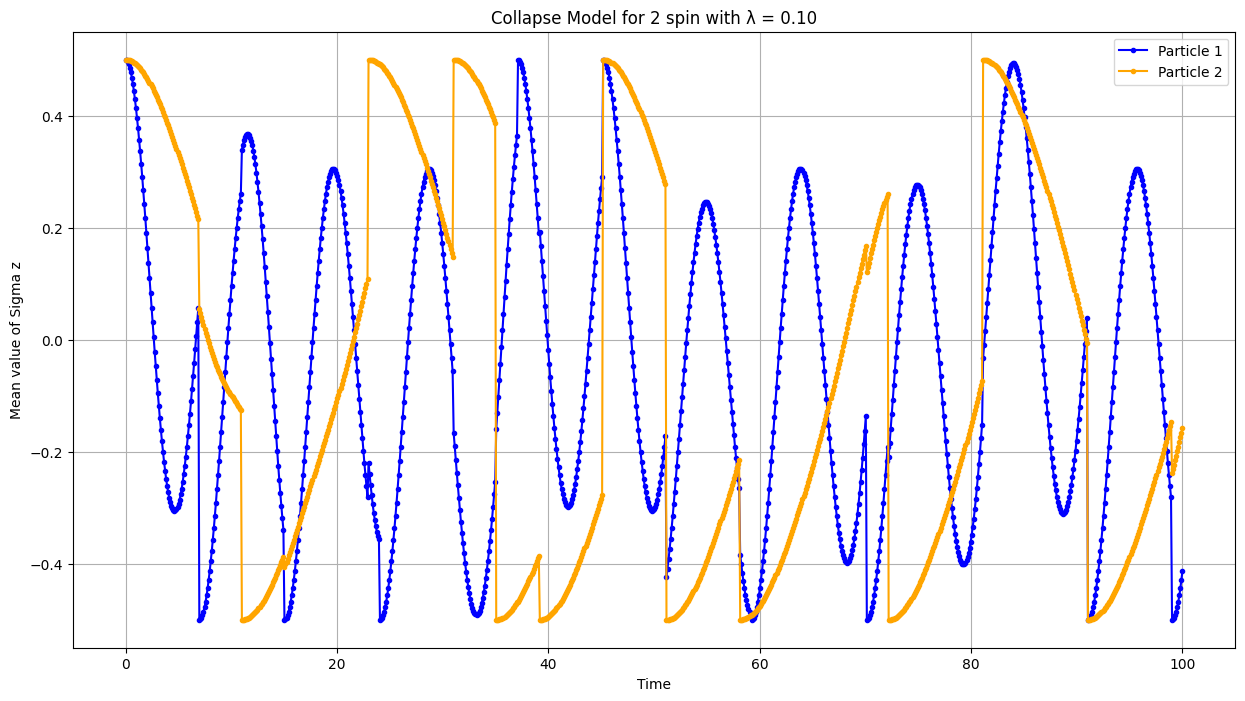

In [38]:
# making the plot


x_times = np.linspace(0,time,num=num_timesteps+t.shape[1]+1)
y1 = np.array(y1)
y2 = np.array(y2)

fig = plt.figure(figsize=(15,8))

plt.plot(x_times,y1,'.-', color = 'blue', label='Particle 1') # mean value of sigma_z for particle 1
plt.plot(x_times,y2,'.-', color = 'orange', label = 'Particle 2') # mean value of sigma_z for particle 2
#plt.plot(c1[0], .6*c1[1], 'o', color = 'orange')
#plt.plot(c2[0], .65*c2[1], 'o', color = 'blue')

plt.xlabel('Time')
plt.ylabel('Mean value of Sigma z')
plt.title(f'Collapse Model for 2 spin with λ = {"{:.2f}".format(true_lam)}')


plt.legend()
plt.grid()


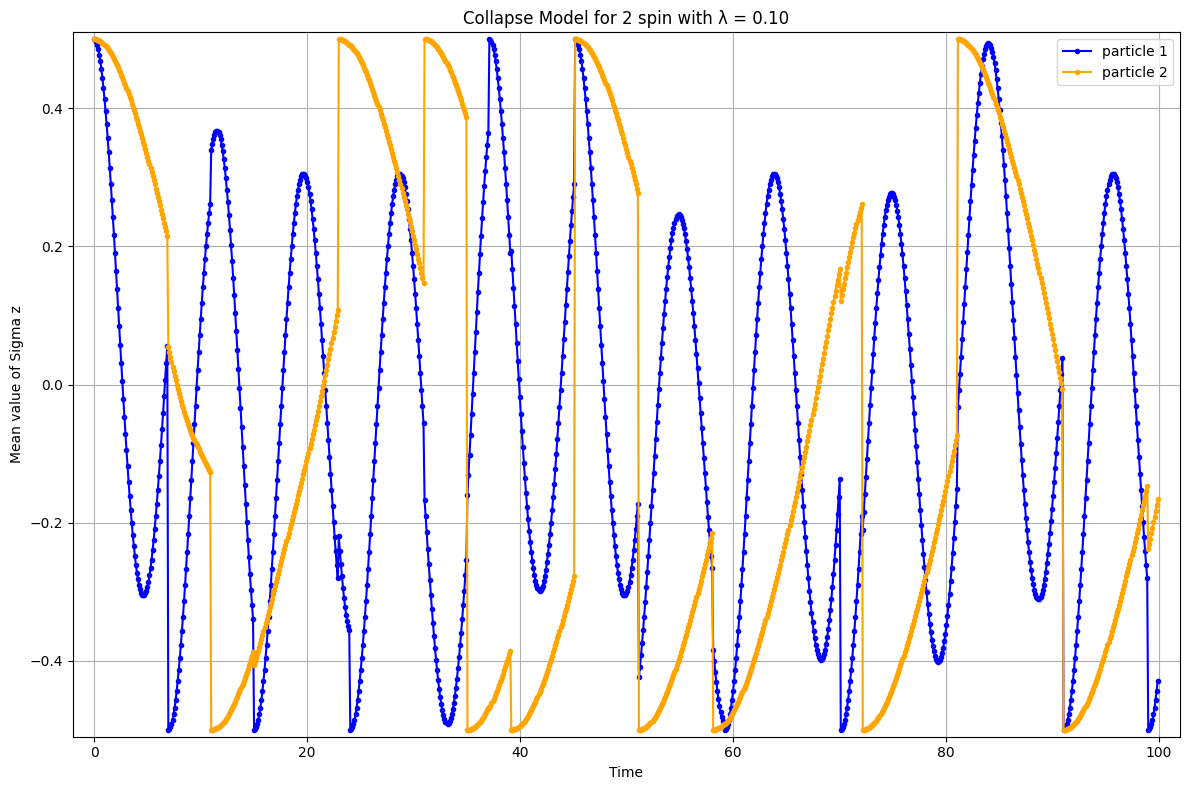

In [42]:
# make the gif
x_times = np.linspace(0,time,num=num_timesteps+t.shape[1]+1)
plot_animation_2(x_times, y1, y2, true_lam, time, save_as_gif=True)

### Trash

In [294]:
initial_state = qi.Statevector.from_label("00")
obs = [obs1, obs2]
QRTE_evolution(hamiltonian, 6, initial_state, 12, obs)

x, y,z = dynamic(hamiltonian, initial_state, 3, 6, obs, 0, 1)

(<qiskit_algorithms.time_evolvers.time_evolution_result.TimeEvolutionResult at 0x15bb11050>,
 array([[0.5, 0.5],
        [0.38242109364224414, 0.47766824456280293],
        [0.14791942059506025, 0.42591144148331345],
        [0.027535937766079918, 0.3747626206319362],
        [0.12363662180380752, 0.33841748300278474],
        [0.3035084431118063, 0.3017067106640539],
        [0.3394449819781211, 0.2377948546467288],
        [0.14856853903689698, 0.1385075570012475],
        [-0.11882993984485922, 0.025448863193307608],
        [-0.2350066617475161, -0.06982186479880709],
        [-0.13150797951154453, -0.13588750399302724],
        [0.03094713004947891, -0.1904236678650404],
        [0.03257355818007557, -0.2587303411015244]], dtype=object))

/var/folders/8r/rk87_q2x6q73135zrfmsjxgw0000gn/T/ipykernel_27358/1167660876.py:61: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  res_state_vector = np.asarray(res_state.tolist()) # convert the output state in a np.array


In [297]:
state_pre = evolution.evolved_state  # extract the circuit from the ouput of the QRTE_evolution  

dig_stat = state_pre

c_reg = ClassicalRegister(2)
dig_stat.add_register(c_reg)

dig_stat.measure(0, c_reg[0])

#Get the state before the collapse as a vector

backend = Aer.get_backend("statevector_simulator")
state = execute(dig_stat, backend).result().get_statevector(dig_stat) # the order is |00>, |01>, |10>, |11>
print("|00>:", state[0])
print("|01>:", state[1])
print("|10>:", state[2])
print("|11>:", state[3])



# WARNING: THIS BLOCK WORK ONLY IF IS REMOVE THE CLASSIC BIT IN THE PREVIOUS BLOCK 

state_pre  = evolution.evolved_state
print("Statevector")
display(array_to_latex(qi.Statevector.from_instruction(state_pre), prefix="\\text{Statevector} = "))

rho = qi.DensityMatrix.from_instruction(state_pre)
print("Density matrix")
rho.draw('latex', prefix='\\rho_{AB} = ')

eof = qi.entanglement_of_formation(rho)
neg = qi.negativity(rho,[1])
sep = len(qi.schmidt_decomposition(rho, [0])) 

print("negativity: ", neg)
print("entanglement of formation: ", eof)
print(sep)
print("")
print(qi.schmidt_decomposition(rho, [0]))

0